In [1]:
import os
# os.environ["KERAS_BACKEND"] = "jax"

import gc
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt

import tensorflow as tf
# import jax
import keras

from sklearn import metrics

from tqdm.notebook import tqdm
import random

print(tf.__version__)
# print(jax.__version__)

2.16.1


In [2]:
def is_interactive():
    return 'runtime' in get_ipython().config.IPKernelApp.connection_file

print('Interactive?', is_interactive())

Interactive? True


In [3]:
SEED = 42
keras.utils.set_random_seed(SEED)
tf.random.set_seed(SEED)
tf.config.experimental.enable_op_determinism()

In [4]:
# DATA = "/kaggle/input/leap-atmospheric-physics-ai-climsim"
DATA_NPY = "data"

In [5]:
sample = pl.read_csv('sample_submission.csv', n_rows=1)
TARGETS = sample.select(pl.exclude('sample_id')).columns
print(len(TARGETS))

368


In [6]:
BATCH_SIZE = 64*20
# train_files = [os.path.join(DATA_NPY, "split_%d.npy" % i) for i in range(1,99)]
# random.shuffle(train_files)
# valid_files = [os.path.join(DATA_NPY, "split_%d.npy" % i) for i in range(99, 102)]
DATA_TFREC = "data"
# create list of all tfrec files in folder and sub folders
TFREC_FILES = tf.io.gfile.glob(DATA_TFREC + '/**/*.tfrecord')
TFREC_FILES = sorted(TFREC_FILES, key=lambda x: os.path.basename(x))
print(len(TFREC_FILES))
train_files = TFREC_FILES[1:3]
valid_files = TFREC_FILES[47:48]
train_options = tf.data.Options()
train_options.deterministic = True

sequence_length = 128

def add_sequence_dim(x, y):
    x = tf.reshape(x, (-1, sequence_length, 556))
    y = tf.reshape(y, (-1, sequence_length, 368))
    return x, y

def _parse_function(example_proto):
    feature_description = {
        'x': tf.io.FixedLenFeature([556], tf.float32),
        'targets': tf.io.FixedLenFeature([368], tf.float32)
    }
    e = tf.io.parse_single_example(example_proto, feature_description)
    return e['x'], e['targets']


ds_train = (
  tf.data.TFRecordDataset(train_files, compression_type="GZIP")
    .with_options(train_options)
  .map(_parse_function, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .map(add_sequence_dim, num_parallel_calls=tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
)

ds_valid = (
    tf.data.TFRecordDataset(valid_files, compression_type="GZIP")
    .map(_parse_function)
    .batch(BATCH_SIZE)
    .map(add_sequence_dim, num_parallel_calls=tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
    )

47


In [7]:
norm_x = keras.layers.Normalization()
norm_x.adapt(ds_train.map(lambda x, y: x).take(1000))

2024-07-02 12:57:48.847744: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [8]:
norm_y = keras.layers.Normalization()
norm_y.adapt(ds_train.map(lambda x, y: y).take(1000))

mean_y = norm_y.mean
stdd_y =keras.ops.maximum(1e-10, norm_y.variance ** 0.5)

2024-07-02 12:58:20.941923: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [9]:
# mean_y = tf.cast(mean_y, tf.float64)
# stdd_y = tf.cast(stdd_y, tf.float64)

In [10]:
# min_y = np.min(np.stack([np.min(yb, 0) for _, yb in ds_train.take(1000)], 0), 0, keepdims=True)
# max_y = np.max(np.stack([np.max(yb, 0) for _, yb in ds_train.take(1000)], 0), 0, keepdims=True)

In [11]:
# min_y = tf.cast(min_y, tf.float64)
# max_y = tf.cast(max_y, tf.float64)

### Model definition & Training

In [12]:
@keras.saving.register_keras_serializable(package="MyMetrics", name="ClippedR2Score")
class ClippedR2Score(keras.metrics.Metric):
    def __init__(self, name='r2_score', **kwargs):
        super().__init__(name=name, **kwargs)
        self.base_metric = keras.metrics.R2Score(class_aggregation=None)
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        self.base_metric.update_state(y_true, y_pred, sample_weight=None)
        
    def result(self):
        return keras.ops.mean(keras.ops.clip(self.base_metric.result(), 0.0, 1.0))
        
    def reset_states(self):
        self.base_metric.reset_states()

In [13]:
epochs = 12
learning_rate = 1e-3

epochs_warmup = 1
epochs_ending = 2
steps_per_epoch = int(np.ceil(len(train_files) * 100_000 / BATCH_SIZE))

lr_scheduler = tf.keras.optimizers.schedules.CosineDecay(
    1e-7,
    (epochs - epochs_warmup - epochs_ending) * steps_per_epoch, 
    warmup_target=learning_rate,
    warmup_steps=steps_per_epoch * epochs_warmup,
    alpha=0.1
)

In [17]:
import keras
import tensorflow as tf

keras.utils.clear_session()

def x_to_seq(x):
    x_seq0 = keras.ops.transpose(keras.ops.reshape(x[:, :, 0:60 * 6], (-1, sequence_length, 6, 60)), (0, 1, 3, 2))
    x_seq1 = keras.ops.transpose(keras.ops.reshape(x[:, :, 60 * 6 + 16:60 * 9 + 16], (-1, sequence_length, 3, 60)), (0, 1, 3, 2))
    x_flat = keras.ops.reshape(x[:, :, 60 * 6:60 * 6 + 16], (-1, sequence_length, 1, 16))
    x_flat = keras.ops.repeat(x_flat, 60, axis=2)
    return keras.ops.concatenate([x_seq0, x_seq1, x_flat], axis=-1)

def build_cnn(activation='relu'):    
    return keras.Sequential([
        # keras.layers.ConvLSTM1D(512, 3, padding='same', activation=activation, return_sequences=True),
        # keras.layers.BatchNormalization(),
        keras.layers.ConvLSTM1D(256, 3, padding='same', activation=activation, return_sequences=True),
        # keras.layers.BatchNormalization(),
        keras.layers.ConvLSTM1D(128, 3, padding='same', activation=activation, return_sequences=True),
        # keras.layers.BatchNormalization(),
        keras.layers.ConvLSTM1D(64, 3, padding='same', activation=activation, return_sequences=True),
        # keras.layers.BatchNormalization(),
        keras.layers.ConvLSTM1D(32, 3, padding='same', activation=activation, return_sequences=True),
        # keras.layers.BatchNormalization(),
        keras.layers.ConvLSTM1D(14, 3, padding='same', activation=activation, return_sequences=True),
        # keras.layers.BatchNormalization(),
    ])

# Input with shape (batch, time_steps, features)
X_input = x = keras.layers.Input(shape=(None, 556))
x = keras.layers.Normalization(mean=norm_x.mean, variance=norm_x.variance)(x)
x = x_to_seq(x)


e = keras.layers.ConvLSTM1D(sequence_length, 3, padding='same', activation='relu', return_sequences=True)(x)
# e = keras.layers.BatchNormalization()(e)
e = build_cnn()(e)
# add global average to allow some comunication between all levels even in a small CNN
# e = e0 + e + keras.layers.GlobalAveragePooling2D(keepdims=True)(e)
# e = keras.layers.BatchNormalization()(e)
# e = e + build_cnn()(e)
# Reshape e to 3D before global pooling
# e = keras.layers.Reshape((-1, 60 * 14))(e)

# Global average pooling to aggregate temporal information
e = keras.layers.GlobalAveragePooling2D()(e)

print(e.shape)
# p_all = keras.layers.ConvLSTM1D(14, 3, padding='same', activation='relu', return_sequences=True)(e)

p_seq = e[:, :, :6]
# p_seq = keras.ops.transpose(p_seq, (0, 1, 3, 2))
# p_seq = keras.ops.reshape(p_seq[:, :, 0:60 * 6], (-1, sequence_length, 360))
assert p_seq.shape[-1] == 360

p_flat = e[:, :, 6*60:]
p_flat = keras.ops.reshape(p_flat, (-1, 60, 8))
p_flat = keras.ops.mean(p_flat, axis=1)
assert p_flat.shape[-1] == 8
combined = keras.ops.concatenate([p_seq, p_flat], axis=1)

# Build & compile
model = keras.Model(inputs=X_input, outputs=combined)
model.compile(
    loss='mse', 
    optimizer=keras.optimizers.Adam(learning_rate, 
                                    # clipnorm=0.5,
                                    ),
    # metrics=[ClippedR2Score()]
)

model.build(input_shape=(None, None, 556))
model.summary()


(None, 14)


ValueError: Array has shape (None, 14) but slice has to many indices. Recieved: `(slice(None, None, None), slice(None, None, None), slice(None, 6, None))`

In [15]:
# model_path = '/kaggle/input/leapseq2seq/model.keras'
# model = tf.keras.models.load_model(model_path)

In [16]:
ds_train_target_normalized = ds_train.map(lambda x, y: (x, (y - mean_y) / stdd_y))
ds_valid_target_normalized = ds_valid.map(lambda x, y: (x, (y - mean_y) / stdd_y))

history = model.fit(
    ds_train_target_normalized.repeat(),
    validation_data=ds_valid_target_normalized.repeat(),
    epochs=epochs,
    verbose=1 if is_interactive() else 2,
    callbacks=[
        keras.callbacks.ModelCheckpoint(filepath='models/convlstm.keras'),
        # keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=2, verbose=1, monitor='val_r2_score', mode='max', min_lr=1e-6)
    ]
)

Epoch 1/12


2024-07-02 12:59:28.124544: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: Incompatible shapes: [10,128,368] vs. [10,368]
	 [[{{function_node __inference_one_step_on_data_72280}}{{node compile_loss/mse/sub}}]]
2024-07-02 12:59:28.124575: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: Incompatible shapes: [10,128,368] vs. [10,368]
	 [[{{function_node __inference_one_step_on_data_72280}}{{node compile_loss/mse/sub}}]]
	 [[Func/StatefulPartitionedCall/gradient_tape/functional_2_1/conv_lstm1d_1/while/functional_2_1/conv_lstm1d_1/while_grad/body/_3428/input/_5852/_2338]]


InvalidArgumentError: Graph execution error:

Detected at node compile_loss/mse/sub defined at (most recent call last):
  File "/Users/johnny/anaconda3/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/Users/johnny/anaconda3/lib/python3.10/runpy.py", line 86, in _run_code

  File "/Users/johnny/Library/CloudStorage/OneDrive-Personal/py/Kaggle/LEAP24/leap24/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/Users/johnny/Library/CloudStorage/OneDrive-Personal/py/Kaggle/LEAP24/leap24/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/Users/johnny/Library/CloudStorage/OneDrive-Personal/py/Kaggle/LEAP24/leap24/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/Users/johnny/Library/CloudStorage/OneDrive-Personal/py/Kaggle/LEAP24/leap24/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/Users/johnny/anaconda3/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/Users/johnny/anaconda3/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/Users/johnny/anaconda3/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/Users/johnny/Library/CloudStorage/OneDrive-Personal/py/Kaggle/LEAP24/leap24/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/Users/johnny/Library/CloudStorage/OneDrive-Personal/py/Kaggle/LEAP24/leap24/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/Users/johnny/Library/CloudStorage/OneDrive-Personal/py/Kaggle/LEAP24/leap24/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/Users/johnny/Library/CloudStorage/OneDrive-Personal/py/Kaggle/LEAP24/leap24/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/Users/johnny/Library/CloudStorage/OneDrive-Personal/py/Kaggle/LEAP24/leap24/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/Users/johnny/Library/CloudStorage/OneDrive-Personal/py/Kaggle/LEAP24/leap24/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/Users/johnny/Library/CloudStorage/OneDrive-Personal/py/Kaggle/LEAP24/leap24/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/Users/johnny/Library/CloudStorage/OneDrive-Personal/py/Kaggle/LEAP24/leap24/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/Users/johnny/Library/CloudStorage/OneDrive-Personal/py/Kaggle/LEAP24/leap24/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/Users/johnny/Library/CloudStorage/OneDrive-Personal/py/Kaggle/LEAP24/leap24/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/Users/johnny/Library/CloudStorage/OneDrive-Personal/py/Kaggle/LEAP24/leap24/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/Users/johnny/Library/CloudStorage/OneDrive-Personal/py/Kaggle/LEAP24/leap24/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/Users/johnny/Library/CloudStorage/OneDrive-Personal/py/Kaggle/LEAP24/leap24/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/var/folders/wh/srwjqw_j5gsbl1y7xdb9jc900000gn/T/ipykernel_32724/4134091713.py", line 4, in <module>

  File "/Users/johnny/Library/CloudStorage/OneDrive-Personal/py/Kaggle/LEAP24/leap24/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/Users/johnny/Library/CloudStorage/OneDrive-Personal/py/Kaggle/LEAP24/leap24/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 314, in fit

  File "/Users/johnny/Library/CloudStorage/OneDrive-Personal/py/Kaggle/LEAP24/leap24/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 117, in one_step_on_iterator

  File "/Users/johnny/Library/CloudStorage/OneDrive-Personal/py/Kaggle/LEAP24/leap24/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 104, in one_step_on_data

  File "/Users/johnny/Library/CloudStorage/OneDrive-Personal/py/Kaggle/LEAP24/leap24/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 54, in train_step

  File "/Users/johnny/Library/CloudStorage/OneDrive-Personal/py/Kaggle/LEAP24/leap24/lib/python3.10/site-packages/keras/src/trainers/trainer.py", line 316, in compute_loss

  File "/Users/johnny/Library/CloudStorage/OneDrive-Personal/py/Kaggle/LEAP24/leap24/lib/python3.10/site-packages/keras/src/trainers/compile_utils.py", line 609, in __call__

  File "/Users/johnny/Library/CloudStorage/OneDrive-Personal/py/Kaggle/LEAP24/leap24/lib/python3.10/site-packages/keras/src/trainers/compile_utils.py", line 645, in call

  File "/Users/johnny/Library/CloudStorage/OneDrive-Personal/py/Kaggle/LEAP24/leap24/lib/python3.10/site-packages/keras/src/losses/loss.py", line 43, in __call__

  File "/Users/johnny/Library/CloudStorage/OneDrive-Personal/py/Kaggle/LEAP24/leap24/lib/python3.10/site-packages/keras/src/losses/losses.py", line 22, in call

  File "/Users/johnny/Library/CloudStorage/OneDrive-Personal/py/Kaggle/LEAP24/leap24/lib/python3.10/site-packages/keras/src/losses/losses.py", line 1158, in mean_squared_error

Detected at node compile_loss/mse/sub defined at (most recent call last):
  File "/Users/johnny/anaconda3/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/Users/johnny/anaconda3/lib/python3.10/runpy.py", line 86, in _run_code

  File "/Users/johnny/Library/CloudStorage/OneDrive-Personal/py/Kaggle/LEAP24/leap24/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/Users/johnny/Library/CloudStorage/OneDrive-Personal/py/Kaggle/LEAP24/leap24/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/Users/johnny/Library/CloudStorage/OneDrive-Personal/py/Kaggle/LEAP24/leap24/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/Users/johnny/Library/CloudStorage/OneDrive-Personal/py/Kaggle/LEAP24/leap24/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/Users/johnny/anaconda3/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/Users/johnny/anaconda3/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/Users/johnny/anaconda3/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/Users/johnny/Library/CloudStorage/OneDrive-Personal/py/Kaggle/LEAP24/leap24/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/Users/johnny/Library/CloudStorage/OneDrive-Personal/py/Kaggle/LEAP24/leap24/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/Users/johnny/Library/CloudStorage/OneDrive-Personal/py/Kaggle/LEAP24/leap24/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/Users/johnny/Library/CloudStorage/OneDrive-Personal/py/Kaggle/LEAP24/leap24/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/Users/johnny/Library/CloudStorage/OneDrive-Personal/py/Kaggle/LEAP24/leap24/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/Users/johnny/Library/CloudStorage/OneDrive-Personal/py/Kaggle/LEAP24/leap24/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/Users/johnny/Library/CloudStorage/OneDrive-Personal/py/Kaggle/LEAP24/leap24/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/Users/johnny/Library/CloudStorage/OneDrive-Personal/py/Kaggle/LEAP24/leap24/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/Users/johnny/Library/CloudStorage/OneDrive-Personal/py/Kaggle/LEAP24/leap24/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/Users/johnny/Library/CloudStorage/OneDrive-Personal/py/Kaggle/LEAP24/leap24/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/Users/johnny/Library/CloudStorage/OneDrive-Personal/py/Kaggle/LEAP24/leap24/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/Users/johnny/Library/CloudStorage/OneDrive-Personal/py/Kaggle/LEAP24/leap24/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/Users/johnny/Library/CloudStorage/OneDrive-Personal/py/Kaggle/LEAP24/leap24/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/var/folders/wh/srwjqw_j5gsbl1y7xdb9jc900000gn/T/ipykernel_32724/4134091713.py", line 4, in <module>

  File "/Users/johnny/Library/CloudStorage/OneDrive-Personal/py/Kaggle/LEAP24/leap24/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/Users/johnny/Library/CloudStorage/OneDrive-Personal/py/Kaggle/LEAP24/leap24/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 314, in fit

  File "/Users/johnny/Library/CloudStorage/OneDrive-Personal/py/Kaggle/LEAP24/leap24/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 117, in one_step_on_iterator

  File "/Users/johnny/Library/CloudStorage/OneDrive-Personal/py/Kaggle/LEAP24/leap24/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 104, in one_step_on_data

  File "/Users/johnny/Library/CloudStorage/OneDrive-Personal/py/Kaggle/LEAP24/leap24/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 54, in train_step

  File "/Users/johnny/Library/CloudStorage/OneDrive-Personal/py/Kaggle/LEAP24/leap24/lib/python3.10/site-packages/keras/src/trainers/trainer.py", line 316, in compute_loss

  File "/Users/johnny/Library/CloudStorage/OneDrive-Personal/py/Kaggle/LEAP24/leap24/lib/python3.10/site-packages/keras/src/trainers/compile_utils.py", line 609, in __call__

  File "/Users/johnny/Library/CloudStorage/OneDrive-Personal/py/Kaggle/LEAP24/leap24/lib/python3.10/site-packages/keras/src/trainers/compile_utils.py", line 645, in call

  File "/Users/johnny/Library/CloudStorage/OneDrive-Personal/py/Kaggle/LEAP24/leap24/lib/python3.10/site-packages/keras/src/losses/loss.py", line 43, in __call__

  File "/Users/johnny/Library/CloudStorage/OneDrive-Personal/py/Kaggle/LEAP24/leap24/lib/python3.10/site-packages/keras/src/losses/losses.py", line 22, in call

  File "/Users/johnny/Library/CloudStorage/OneDrive-Personal/py/Kaggle/LEAP24/leap24/lib/python3.10/site-packages/keras/src/losses/losses.py", line 1158, in mean_squared_error

2 root error(s) found.
  (0) INVALID_ARGUMENT:  Incompatible shapes: [10,128,368] vs. [10,368]
	 [[{{node compile_loss/mse/sub}}]]
	 [[Func/StatefulPartitionedCall/gradient_tape/functional_2_1/conv_lstm1d_1/while/functional_2_1/conv_lstm1d_1/while_grad/body/_3428/input/_5852/_2338]]
  (1) INVALID_ARGUMENT:  Incompatible shapes: [10,128,368] vs. [10,368]
	 [[{{node compile_loss/mse/sub}}]]
0 successful operations.
0 derived errors ignored. [Op:__inference_one_step_on_iterator_72403]

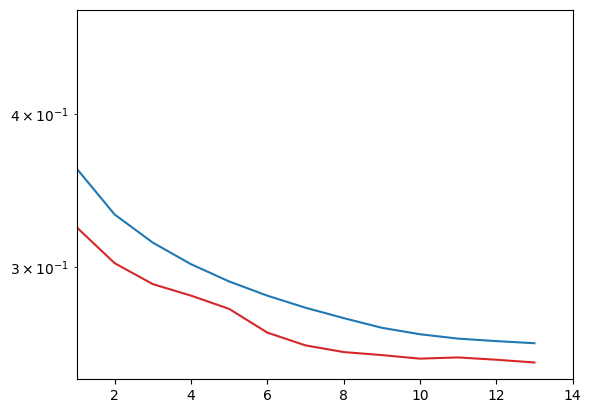

In [ ]:
plt.plot(history.history['loss'], color='tab:blue')
plt.plot(history.history['val_loss'], color='tab:red')
plt.xlim(1, epochs)
plt.yscale('log');

In [ ]:
y_valid = np.concatenate([yb for _, yb in ds_valid])
p_valid = model.predict(ds_valid, batch_size=BATCH_SIZE) * stdd_y + mean_y

2024-06-18 04:16:40.008407: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 241ms/step


2024-06-18 04:16:46.511924: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
p_valid.numpy()[0]

array([ 4.41540104e-05,  1.17593669e-05,  4.99364276e-05,  1.15849704e-04,
        1.18762283e-04,  1.38168927e-04,  1.31325779e-04,  1.11941738e-04,
        7.62355657e-05,  5.59894341e-05,  4.06329638e-05,  3.11236676e-05,
        2.56126911e-05,  2.11678961e-05,  1.49962994e-05,  1.05332451e-05,
        6.01114352e-06,  8.90657996e-06, -5.86432859e-07,  4.55248142e-06,
        3.29134006e-06,  1.29633768e-06,  1.32082633e-06,  1.02777386e-05,
        1.76192279e-05,  2.03575447e-05,  1.02421570e-05, -1.28409899e-06,
       -6.64042517e-06,  1.97603013e-06,  3.51795970e-06, -4.53778344e-06,
       -2.73701807e-06,  4.17617149e-07, -1.50799410e-05,  2.34765585e-05,
        7.83000655e-05,  9.01033915e-05,  9.75927030e-05,  8.52953681e-05,
        5.26527270e-05,  2.41996422e-05, -4.08920331e-06, -1.48055111e-05,
       -2.86923796e-05, -2.89012558e-05, -2.85687950e-05, -1.64398009e-05,
       -1.43812486e-05, -1.13749088e-05, -1.07844372e-05, -1.60867953e-05,
       -1.64829452e-05, -

In [ ]:
scores_valid = np.array([metrics.r2_score(y_valid[:, i], p_valid[:, i]) for i in range(len(TARGETS))])
plt.plot(scores_valid.clip(-1, 1))

ValueError: Input arrays use different devices: cpu, /job:localhost/replica:0/task:0/device:CPU:0

In [ ]:
mask = scores_valid <= 1e-3
f"Number of under-performing targets: {sum(mask)}"

In [ ]:
f"Clipped score: {scores_valid.clip(0, 1).mean()}"

In [ ]:
del y_valid, p_valid
gc.collect();